# Deep bootstrap framework
ref: https://arxiv.org/abs/2010.08127

In [1]:
# import supporting libraries
import torch
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import pickle
import os

# set seed to ensure reproducibility
torch.manual_seed(8)

## CIFAR10

In [ ]:
# transformation steps for training and test set upon loading the dataset
transform = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                           std=(0.5, 0.5, 0.5))])
# download the CIFAR10 dataset
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, 
                                    transform=transform) 
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, 
                                      transform=transform)
# define data loader that reads 100 images at a time
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, 
                                              shuffle=True) 
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size = 100, shuffle=False)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, 
                              stride=1, padding=1) 
        # double the depth of feature maps for every conv layer
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1) 
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        # input image is 32*32, after 3 MaxPooling layers it reduces to 4*4 64 feature maps
        self.fc1 = nn.Linear(4*4*64, 500) 
        self.dropout1 = nn.Dropout(0.5)
        # 10 output nodes that map to 10 classes
        self.fc2 = nn.Linear(500, 10) 

    def forward(self, x):
        # apply relu to each conv layer output
        x = F.relu(self.conv1(x)) 
        # max pooling layer with 2x2 kernel to shrink the size by half
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        # flatten the images as 1D input to the fully connected layer
        # x = x.view(-1, 4*4*64) 
        x = x.reshape(-1, 4*4*64) 
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [ ]:
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device) 
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of parameters: 541094


In [ ]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
%%time

epochs = 100
training_loss_history = []
training_error_history = []
training_softerror_history = []
test_loss_history = []
test_error_history = []
test_softerror_history = []

# iterate over 500 batches for 100 epoches; 50000 SGD iterations in total
for e in range(epochs): 
    training_loss = 0.0
    training_accuracy = 0.0
    training_error = 0.0
    training_softerror = 0.0
    test_loss = 0.0
    test_accuracy = 0.0
    test_error = 0.0
    test_softerror = 0.0
    for inputs, labels in training_loader:
        inputs = inputs.to(device) 
        labels = labels.to(device)
        outputs = model(inputs) 
        loss = criterion(outputs, labels) 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        _, preds = torch.max(outputs, 1) 
        # retrive the softmax probability 
        correct_class_prob = torch.exp(outputs[torch.arange(len(outputs)), 
                                               labels.data]) / \
                                               torch.sum(torch.exp(outputs), 1)
        training_loss += loss.item()
        training_accuracy += torch.sum(preds == labels.data)
        training_softerror += torch.sum(correct_class_prob)

    training_loss = training_loss/len(training_loader)
    # calculate the proportion of wrong predictions in the training set
    training_error = 1 - training_accuracy/len(training_dataset)
    # calculate the softerror based on the average predicted probability of the correct class label
    training_softerror = 1 - training_softerror/len(training_dataset)
    # check validation performance for each SGD iteration
    with torch.no_grad(): 
        for val_inputs, val_labels in validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss_model = criterion(val_outputs, val_labels)
            _, val_preds = torch.max(val_outputs, 1)
            test_correct_class_prob = torch.exp(val_outputs[torch.arange(len(val_outputs)), 
                                            val_labels.data]) / \
                                            torch.sum(torch.exp(val_outputs), 1)
            test_loss += val_loss_model.item()
            test_accuracy += torch.sum(val_preds == val_labels.data)
            test_softerror += torch.sum(test_correct_class_prob)
    test_loss = test_loss/len(validation_loader)
    test_error = 1 - test_accuracy/len(validation_dataset)
    test_softerror = 1 - test_softerror/len(validation_dataset)
    # append to master list for visualization
    training_loss_history.append(training_loss) 
    training_error_history.append(training_error.item())
    training_softerror_history.append(training_softerror.item())
    test_loss_history.append(test_loss) 
    test_error_history.append(test_error.item())
    test_softerror_history.append(test_softerror.item())
        
    print('Epoch :', (e+1))
    print('Training loss: {:.4f}, error {:.4f} '.format(training_loss, training_error.item()))
    print('Test loss: {:.4f}, Test error {:.4f} '.format(test_loss, test_error.item()))


Epoch : 1
Training loss: 2.2957, error 0.8587 
Test loss: 2.2802, Test error 0.8211 
Epoch : 2
Training loss: 2.1740, error 0.7778 
Test loss: 2.0345, Test error 0.7267 
Epoch : 3
Training loss: 1.9568, error 0.7017 
Test loss: 1.8640, Test error 0.6731 
Epoch : 4
Training loss: 1.7995, error 0.6474 
Test loss: 1.7044, Test error 0.6120 
Epoch : 5
Training loss: 1.6695, error 0.6046 
Test loss: 1.6180, Test error 0.5905 
Epoch : 6
Training loss: 1.5876, error 0.5763 
Test loss: 1.5429, Test error 0.5608 
Epoch : 7
Training loss: 1.5286, error 0.5556 
Test loss: 1.4928, Test error 0.5414 
Epoch : 8
Training loss: 1.4802, error 0.5370 
Test loss: 1.4381, Test error 0.5183 
Epoch : 9
Training loss: 1.4425, error 0.5237 
Test loss: 1.4158, Test error 0.5141 
Epoch : 10
Training loss: 1.4050, error 0.5063 
Test loss: 1.3849, Test error 0.5001 
Epoch : 11
Training loss: 1.3731, error 0.4942 
Test loss: 1.3584, Test error 0.4901 
Epoch : 12
Training loss: 1.3410, error 0.4842 
Test loss: 1.36

In [ ]:
stats_cifar10 = {"training_loss_history":training_loss_history, 
                 "training_error_history":training_error_history,
                 "training_softerror_history":training_softerror_history,
                 "test_loss_history":test_loss_history,
                 "test_error_history":test_error_history,
                 "test_softerror_history":test_softerror_history}
stats_name = "stats_cifar10.pkl"  
with open(stats_name, 'wb') as file:  
    pickle.dump(stats_cifar10, file)

from google.colab import files
files.download("/content/stats_cifar10.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## CIFAR10-5m

In [ ]:
# download CIFAR10-5m dataset
for i in range(0,6):
    !gsutil cp -r gs://gresearch/cifar5m/part{i}.npz .

Copying gs://gresearch/cifar5m/part0.npz...
\ [1 files][  2.9 GiB/  2.9 GiB]   64.1 MiB/s                                   
Operation completed over 1 objects/2.9 GiB.                                      
Copying gs://gresearch/cifar5m/part1.npz...


In [4]:
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device) 
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [5]:
# custom tensor dataset that supports transform operations
class CustomTensorDataset(torch.utils.data.Dataset):
    def __init__(self, tensors, transform=None):
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transform:
            x = self.transform(x)
        y = self.tensors[1][index]
        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.ToTensor(), 
                                      transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                           std=(0.5, 0.5, 0.5))])

In [6]:
%%time
# RUN FOR ALL TRAINING DATA
training_loss_history_5m = []
training_error_history_5m = []
training_softerror_history_5m = []
test_loss_history_5m = []
test_error_history_5m = []
test_softerror_history_5m = []
# folder to store all 100 checkpoint models
if not os.path.exists('models'):
    os.makedirs('models')

for i in range(5):
    print(f"======== Dataset {i+1} ======")
    # refresh data loader
    train_X = np.load(f"part{i}.npz")['X']
    train_Y = np.load(f"part{i}.npz")['Y']
    # transform to torch tensor
    train_X = torch.Tensor(train_X) 
    train_Y = torch.Tensor(train_Y)
    # DATALOADER WITH TRANFORM #####
    training_dataset = CustomTensorDataset(tensors=(train_X.permute(0, 3, 1, 2), 
                                                    train_Y), transform=transform)
    training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100)
    # save some RAM space by deleting unnecessary objects
    del train_X, train_Y, training_dataset
    ##### START OF TRAINING
    training_loss = 0.0
    training_accuracy = 0.0
    training_error = 0.0
    training_softerror = 0.0
    test_loss = 0.0
    test_accuracy = 0.0
    test_error = 0.0
    test_softerror = 0.0
    for idx, (inputs, labels) in enumerate(training_loader):
        inputs = inputs.to(device)
        labels = labels.to(torch.int64).to(device)
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels) 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        _, preds = torch.max(outputs, 1) 
        # retrieve the softmax probability 
        correct_class_prob = torch.exp(outputs[torch.arange(len(outputs)), 
                                              labels.data]) / \
                                              torch.sum(torch.exp(outputs), 1)
        training_loss += loss.item()
        training_accuracy += torch.sum(preds == labels.data)
        training_softerror += torch.sum(correct_class_prob)
        # increment the index to start at 1
        idx2 = idx + 1
        if idx2 % 500 == 0:
            training_loss = training_loss/500
            # calculate the proportion of wrong predictions in training 
            training_error = 1 - training_accuracy/50000
            # calculate the softerror based on the average predicted probability of the correct class label
            training_softerror = 1 - training_softerror/50000
            # accuracy per 50000 trining images
            training_epoch_acc = training_accuracy.float()/50000
            # append to master list for visualization
            training_loss_history_5m.append(training_loss) 
            training_error_history_5m.append(training_error.item())
            training_softerror_history_5m.append(training_softerror.item())
            # save models
            model_name = f"models/model_{idx2//500+i*20}.pkl"  
            with open(model_name, 'wb') as file:  
                pickle.dump(model, file)
            print(f"model {idx2//500+i*20} saved")
            print('Samples passed through in current dataset:', (idx2//500)*50000)
            print('Training loss: {:.4f}, accuracy: {:.4f}, error {:.4f}, \
            softerror {:.4f} '.format(training_loss, training_epoch_acc.item(), 
                                      training_error.item(), training_softerror.item()))
            # reset within-epoch metrics
            training_loss = 0.0
            training_accuracy = 0.0
            training_error = 0.0
            training_softerror = 0.0
            test_loss = 0.0
            test_accuracy = 0.0
            test_error = 0.0
            test_softerror = 0.0
    
    del training_loader


======== Dataset 1 ======
model 1 saved
Samples passed through in current dataset: 50000
Training loss: 2.2846, accuracy: 0.1269, error 0.8731,             softerror 0.8978 
model 2 saved
Samples passed through in current dataset: 100000
Training loss: 2.0810, accuracy: 0.2499, error 0.7501,             softerror 0.8583 
model 3 saved
Samples passed through in current dataset: 150000
Training loss: 1.8962, accuracy: 0.3160, error 0.6840,             softerror 0.8118 
model 4 saved
Samples passed through in current dataset: 200000
Training loss: 1.7285, accuracy: 0.3798, error 0.6202,             softerror 0.7635 
model 5 saved
Samples passed through in current dataset: 250000
Training loss: 1.5786, accuracy: 0.4362, error 0.5638,             softerror 0.7162 
model 6 saved
Samples passed through in current dataset: 300000
Training loss: 1.4744, accuracy: 0.4683, error 0.5317,             softerror 0.6830 
model 7 saved
Samples passed through in current dataset: 350000
Training loss: 1.

In [ ]:
# download all models
!zip -r /content/models.zip /content/models
from google.colab import files
files.download("/content/models.zip")

  adding: content/models/ (stored 0%)
  adding: content/models/model_19.0.pkl (deflated 8%)
  adding: content/models/model_47.0.pkl (deflated 8%)
  adding: content/models/model_10.0.pkl (deflated 8%)
  adding: content/models/model_20.0.pkl (deflated 8%)
  adding: content/models/model_15.0.pkl (deflated 8%)
  adding: content/models/model_73.0.pkl (deflated 8%)
  adding: content/models/model_16.0.pkl (deflated 8%)
  adding: content/models/model_33.0.pkl (deflated 8%)
  adding: content/models/model_14.0.pkl (deflated 8%)
  adding: content/models/model_30.0.pkl (deflated 8%)
  adding: content/models/model_32.0.pkl (deflated 8%)
  adding: content/models/model_85.0.pkl (deflated 8%)
  adding: content/models/model_18.0.pkl (deflated 8%)
  adding: content/models/model_74.0.pkl (deflated 8%)
  adding: content/models/model_3.0.pkl (deflated 9%)
  adding: content/models/model_53.0.pkl (deflated 8%)
  adding: content/models/model_92.0.pkl (deflated 8%)
  adding: content/models/model_34.0.pkl (defl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
stats_cifar10_5m_training = {"training_loss_history_5m":training_loss_history_5m,
                 "training_error_history_5m":training_error_history_5m,
                 "training_softerror_history_5m":training_softerror_history_5m}
stats_name = "stats_cifar10_5m_training.pkl"  
with open(stats_name, 'wb') as file:  
    pickle.dump(stats_cifar10_5m_training, file)
from google.colab import files
files.download("/content/stats_cifar10_5m_training.pkl")

NameError: ignored

In [ ]:
# test set from CIFAR10-5m
test_X = np.load(f"part5.npz")['X']
test_Y = np.load(f"part5.npz")['Y']

# transform to torch tensor
test_X = torch.Tensor(test_X) 
test_Y = torch.Tensor(test_Y)

#### DATALOADER WITH TRANFORM #####
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.ToTensor(), 
                                      transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                          std=(0.5, 0.5, 0.5))])
test_dataset = CustomTensorDataset(tensors=(test_X.permute(0, 3, 1, 2), test_Y), transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

del test_X, test_Y, test_dataset

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss() 

test_loss_history_5m = []
test_error_history_5m = []
test_softerror_history_5m = []
test_loss = 0.0
test_accuracy = 0.0
test_error = 0.0
test_softerror = 0.0

for i in range(1,101):
    # load model
    filename = f"models/model_{i}.pkl"
    model = pickle.load(open(filename, 'rb'))
    # score across the whole test set
    with torch.no_grad(): 
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(torch.int64).to(device)
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels) 
            _, preds = torch.max(outputs, 1) 
            # retrive the softmax probability 
            correct_class_prob = torch.exp(outputs[torch.arange(len(outputs)), 
                                                  labels.data]) / \
                                                  torch.sum(torch.exp(outputs), 1)
            test_loss += loss.item()
            test_accuracy += torch.sum(preds == labels.data)
            test_softerror += torch.sum(correct_class_prob)

    test_loss = test_loss/len(test_loader)
    # calculate the proportion of wrong predictions in the test set
    test_error = 1 - test_accuracy/(len(test_loader)*100)
    # calculate the softerror based on the average predicted probability of the correct class label
    test_softerror = 1 - test_softerror/(len(test_loader)*100)
    # accuracy per epoch
    test_accuracy = test_accuracy.float()/(len(test_loader)*100)
    # append to master list for visualization
    test_loss_history_5m.append(test_loss) 
    test_error_history_5m.append(test_error.item())
    test_softerror_history_5m.append(test_softerror.item())
    print(f"===== model {i} =====")
    print('Test loss: {:.4f}, accuracy: {:.4f}, error {:.4f}, softerror {:.4f} '.format(test_loss, test_accuracy.item(), test_error.item(), test_softerror.item()))

    test_loss = 0.0
    test_accuracy = 0.0
    test_error = 0.0
    test_softerror = 0.0


FileNotFoundError: ignored

In [ ]:
stats_cifar10_5m_test = {"test_loss_history_5m":test_loss_history_5m,
                 "test_error_history_5m":test_error_history_5m,
                 "test_softerror_history_5m":test_softerror_history_5m}
stats_name = "stats_cifar10_5m_test.pkl"  
with open(stats_name, 'wb') as file:  
    pickle.dump(stats_cifar10_5m_test, file)

from google.colab import files
files.download("/content/stats_cifar10_5m_test.pkl")

### Differences between real world and ideal world

In [ ]:
stats_cifar10 = pickle.load(open("stats_cifar10.pkl", 'rb'))
stats_cifar10_5m = pickle.load(open("stats_cifar10_5m.pkl", 'rb'))

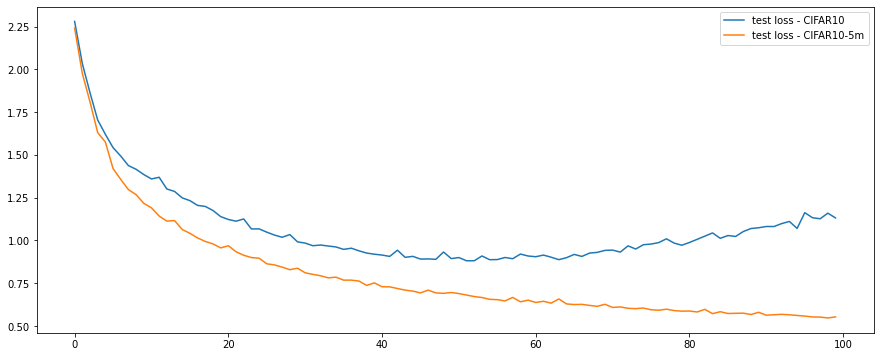

In [ ]:
# plt.rcParams["figure.figsize"] = (15,6)
fig=plt.figure()
plt.plot(stats_cifar10['test_loss_history'], label='test loss - CIFAR10')
plt.plot(stats_cifar10_5m['test_loss_history_5m'], label='test loss - CIFAR10-5m')
plt.legend()

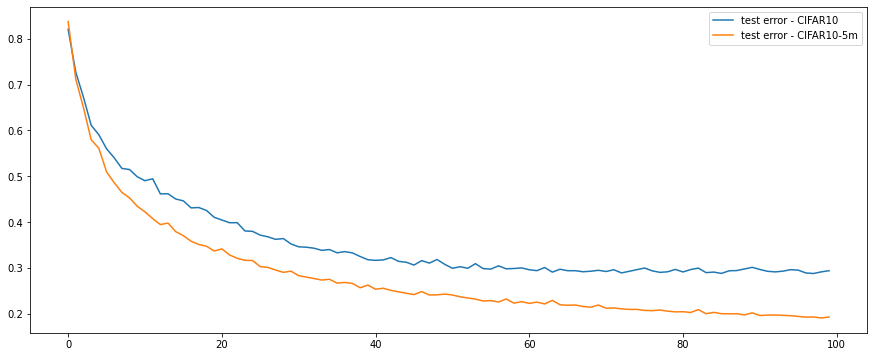

In [ ]:
plt.plot(stats_cifar10['test_error_history'], label='test error - CIFAR10')
plt.plot(stats_cifar10_5m['test_error_history_5m'], label='test error - CIFAR10-5m')
plt.legend()

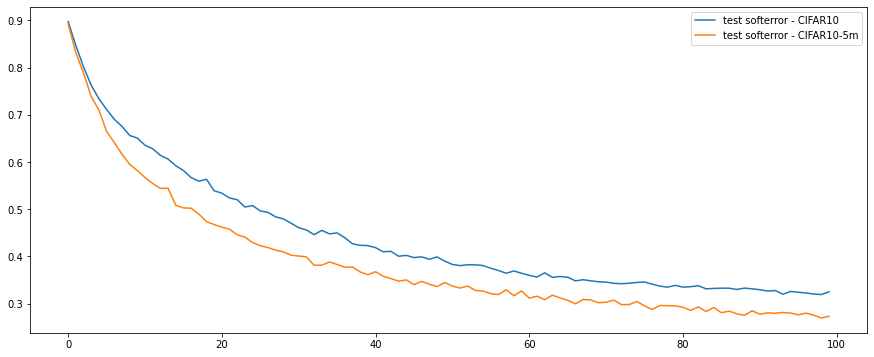

In [ ]:
plt.plot(stats_cifar10['test_softerror_history'], label='test softerror - CIFAR10')
plt.plot(stats_cifar10_5m['test_softerror_history_5m'], label='test softerror - CIFAR10-5m')
plt.legend()

# Implicit bias

In [ ]:
class LeNet_FC(nn.Module):
    def __init__(self):
        super().__init__()
        # input image is 32*32, after 3 MaxPooling layers it reduces to 4*4 64 feature maps
        self.fc1 = nn.Linear(32*32*3, 10000)
        self.fc2 = nn.Linear(10000, 5000) 
        self.fc3 = nn.Linear(5000, 2500) 
        self.fc4 = nn.Linear(2500, 1000) 
        # 10 output nodes that map to 10 classes
        self.fc5 = nn.Linear(1000, 10) 
        self.dropout1 = nn.Dropout(0.5)
        
    def forward(self, x):
        # flatten the images as 1D input to the fully connected layer
        x = x.reshape(-1, 32*32*3) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.dropout1(x)
        x = self.fc5(x)
        return x

CIFAR10

In [ ]:
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LeNet_FC().to(device) 
model

LeNet_FC(
  (fc1): Linear(in_features=3072, out_features=10000, bias=True)
  (fc2): Linear(in_features=10000, out_features=5000, bias=True)
  (fc3): Linear(in_features=5000, out_features=2500, bias=True)
  (fc4): Linear(in_features=2500, out_features=1000, bias=True)
  (fc5): Linear(in_features=1000, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)

In [ ]:
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of parameters: 95748510


In [ ]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
%%time

epochs = 100
training_loss_history = []
training_error_history = []
training_softerror_history = []
test_loss_history = []
test_error_history = []
test_softerror_history = []

# iterate over 500 batches for 100 epoches; 50000 SGD iterations in total
for e in range(epochs): 
    training_loss = 0.0
    training_accuracy = 0.0
    training_error = 0.0
    training_softerror = 0.0
    test_loss = 0.0
    test_accuracy = 0.0
    test_error = 0.0
    test_softerror = 0.0
    for inputs, labels in training_loader:
        inputs = inputs.to(device) 
        labels = labels.to(device)
        outputs = model(inputs) 
        loss = criterion(outputs, labels) 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        _, preds = torch.max(outputs, 1) 
        # retrive the softmax probability 
        correct_class_prob = torch.exp(outputs[torch.arange(len(outputs)), 
                                               labels.data]) / \
                                               torch.sum(torch.exp(outputs), 1)
        training_loss += loss.item()
        training_accuracy += torch.sum(preds == labels.data)
        training_softerror += torch.sum(correct_class_prob)

    training_loss = training_loss/len(training_loader)
    # calculate the proportion of wrong predictions in the training set
    training_error = 1 - training_accuracy/len(training_dataset)
    # calculate the softerror based on the average predicted probability of the correct class label
    training_softerror = 1 - training_softerror/len(training_dataset)
    # check validation performance for each SGD iteration
    with torch.no_grad(): 
        for val_inputs, val_labels in validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss_model = criterion(val_outputs, val_labels)
            _, val_preds = torch.max(val_outputs, 1)
            test_correct_class_prob = torch.exp(val_outputs[torch.arange(len(val_outputs)), 
                                            val_labels.data]) / \
                                            torch.sum(torch.exp(val_outputs), 1)
            test_loss += val_loss_model.item()
            test_accuracy += torch.sum(val_preds == val_labels.data)
            test_softerror += torch.sum(test_correct_class_prob)
    test_loss = test_loss/len(validation_loader)
    test_error = 1 - test_accuracy/len(validation_dataset)
    test_softerror = 1 - test_softerror/len(validation_dataset)
    # append to master list for visualization
    training_loss_history.append(training_loss) 
    training_error_history.append(training_error.item())
    training_softerror_history.append(training_softerror.item())
    test_loss_history.append(test_loss) 
    test_error_history.append(test_error.item())
    test_softerror_history.append(test_softerror.item())
        
    print('Epoch :', (e+1))
    print('Training loss: {:.4f}, error {:.4f} '.format(training_loss, training_error.item()))
    print('Test loss: {:.4f}, Test error {:.4f} '.format(test_loss, test_error.item()))


Epoch : 1
Training loss: 2.2656, error 0.8122 
Test loss: 2.1809, Test error 0.7532 
Epoch : 2
Training loss: 2.0445, error 0.7335 
Test loss: 1.9340, Test error 0.7021 
Epoch : 3
Training loss: 1.8742, error 0.6751 
Test loss: 1.8083, Test error 0.6490 
Epoch : 4
Training loss: 1.7640, error 0.6331 
Test loss: 1.7063, Test error 0.6100 
Epoch : 5
Training loss: 1.6784, error 0.6008 
Test loss: 1.6519, Test error 0.5970 
Epoch : 6
Training loss: 1.6104, error 0.5785 
Test loss: 1.5797, Test error 0.5672 
Epoch : 7
Training loss: 1.5501, error 0.5559 
Test loss: 1.5372, Test error 0.5474 
Epoch : 8
Training loss: 1.4913, error 0.5330 
Test loss: 1.5030, Test error 0.5377 
Epoch : 9
Training loss: 1.4365, error 0.5120 
Test loss: 1.4457, Test error 0.5180 
Epoch : 10
Training loss: 1.3855, error 0.4944 
Test loss: 1.4330, Test error 0.5084 
Epoch : 11
Training loss: 1.3370, error 0.4760 
Test loss: 1.4124, Test error 0.5010 
Epoch : 12
Training loss: 1.2884, error 0.4585 
Test loss: 1.37

In [ ]:
stats_cifar10 = {"training_loss_history":training_loss_history, 
                 "training_error_history":training_error_history,
                 "training_softerror_history":training_softerror_history,
                 "test_loss_history":test_loss_history,
                 "test_error_history":test_error_history,
                 "test_softerror_history":test_softerror_history}
stats_name = "stats_cifar10_LENETFC.pkl"  
with open(stats_name, 'wb') as file:  
    pickle.dump(stats_cifar10, file)

from google.colab import files
files.download("/content/stats_cifar10_LENETFC.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CIFAR10-5m

In [ ]:
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LeNet_FC().to(device) 
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
%%time
# RUN FOR ALL TRAINING DATA
import pickle 

training_loss_history_5m = []
training_error_history_5m = []
training_softerror_history_5m = []
test_loss_history_5m = []
test_error_history_5m = []
test_softerror_history_5m = []

import os
if not os.path.exists('models'):
    os.makedirs('models')

for i in range(5):
    print(f"======== Dataset {i+1} ======")

    # refresh data loader
    train_X = np.load(f"part{i}.npz")['X']
    train_Y = np.load(f"part{i}.npz")['Y']
    # transform to torch tensor
    train_X = torch.Tensor(train_X) 
    train_Y = torch.Tensor(train_Y)

    ###### DATALOADER WITHOUT TRANFORM #####
    # # create tensor dataset
    # training_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)
    # # create dataloader
    # training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100)

    ##### DATALOADER WITH TRANFORM #####
    transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.ToTensor(), 
                                          transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                              std=(0.5, 0.5, 0.5))])
    training_dataset = CustomTensorDataset(tensors=(train_X.permute(0, 3, 1, 2), train_Y), transform=transform)
    training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100)

    del train_X, train_Y, training_dataset

    ##### START OF TRAINING
    training_loss = 0.0
    training_accuracy = 0.0
    training_error = 0.0
    training_softerror = 0.0
    test_loss = 0.0
    test_accuracy = 0.0
    test_error = 0.0
    test_softerror = 0.0
    for idx, (inputs, labels) in enumerate(training_loader):
        inputs = inputs.to(device)
        labels = labels.to(torch.int64).to(device)
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels) 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        _, preds = torch.max(outputs, 1) 
        # retrive the softmax probability 
        correct_class_prob = torch.exp(outputs[torch.arange(len(outputs)), 
                                              labels.data]) / \
                                              torch.sum(torch.exp(outputs), 1)
        training_loss += loss.item()
        training_accuracy += torch.sum(preds == labels.data)
        training_softerror += torch.sum(correct_class_prob)

        idx2 = idx + 1
        if idx2 % 500 == 0:
            training_loss = training_loss/500
            # calculate the proportion of wrong predictions in the training set
            training_error = 1 - training_accuracy/50000
            # calculate the softerror based on the average predicted probability of the correct class label
            training_softerror = 1 - training_softerror/50000
            # accuracy per epoch
            training_epoch_acc = training_accuracy.float()/50000
            # test_epoch_acc = test_accuracy.float()/ len(validation_loader)
            # # append to master list for visualization
            training_loss_history_5m.append(training_loss) 
            training_error_history_5m.append(training_error.item())
            training_softerror_history_5m.append(training_softerror.item())
            # save models
            model_name = f"models/model_{idx//500+i*20}.pkl"  
            with open(model_name, 'wb') as file:  
                pickle.dump(model, file)
            print(f"model {idx//500+i*20} saved")
            print('Samples passed through in current dataset:', (idx//500)*50000)
            print('Training loss: {:.4f}, accuracy: {:.4f}, error {:.4f}, softerror {:.4f} '.format(training_loss, training_epoch_acc.item(), training_error.item(), training_softerror.item()))

            training_loss = 0.0
            training_accuracy = 0.0
            training_error = 0.0
            training_softerror = 0.0
            test_loss = 0.0
            test_accuracy = 0.0
            test_error = 0.0
            test_softerror = 0.0
    
    del training_loader


======== Dataset 1 ======
model 0 saved
Samples passed through in current dataset: 0
Training loss: 2.2529, accuracy: 0.1829, error 0.8171, softerror 0.8939 
model 1 saved
Samples passed through in current dataset: 50000
Training loss: 1.9772, accuracy: 0.2906, error 0.7094, softerror 0.8417 
model 2 saved
Samples passed through in current dataset: 100000
Training loss: 1.7586, accuracy: 0.3742, error 0.6258, softerror 0.7800 
model 3 saved
Samples passed through in current dataset: 150000
Training loss: 1.6207, accuracy: 0.4215, error 0.5785, softerror 0.7345 
model 4 saved
Samples passed through in current dataset: 200000
Training loss: 1.5141, accuracy: 0.4629, error 0.5371, softerror 0.6957 
model 5 saved
Samples passed through in current dataset: 250000
Training loss: 1.4435, accuracy: 0.4896, error 0.5104, softerror 0.6692 
model 6 saved
Samples passed through in current dataset: 300000
Training loss: 1.3906, accuracy: 0.5095, error 0.4905, softerror 0.6463 
model 7 saved
Samples

In [ ]:
# download all models
!zip -r /content/models.zip /content/models
from google.colab import files
files.download("/content/models.zip")

  adding: content/models/ (stored 0%)
  adding: content/models/model_45.pkl (deflated 8%)
  adding: content/models/model_82.pkl (deflated 8%)
  adding: content/models/model_7.pkl (deflated 8%)
  adding: content/models/model_17.pkl (deflated 8%)
  adding: content/models/model_57.pkl (deflated 8%)
  adding: content/models/model_68.pkl (deflated 8%)
  adding: content/models/model_24.pkl (deflated 8%)
  adding: content/models/model_36.pkl (deflated 8%)
  adding: content/models/model_73.pkl (deflated 8%)
  adding: content/models/model_40.pkl (deflated 8%)
  adding: content/models/model_9.pkl (deflated 8%)
  adding: content/models/model_13.pkl (deflated 8%)
  adding: content/models/model_79.pkl (deflated 8%)
  adding: content/models/model_53.pkl (deflated 8%)
  adding: content/models/model_41.pkl (deflated 8%)
  adding: content/models/model_3.pkl (deflated 8%)
  adding: content/models/model_78.pkl (deflated 8%)
  adding: content/models/model_67.pkl (deflated 8%)
  adding: content/models/mode

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
stats_cifar10_5m_training_LENETFC = {"training_loss_history_5m":training_loss_history_5m,
                 "training_error_history_5m":training_error_history_5m,
                 "training_softerror_history_5m":training_softerror_history_5m}
stats_name = "stats_cifar10_5m_training_LENETFC.pkl"  
with open(stats_name, 'wb') as file:  
    pickle.dump(stats_cifar10_5m_training_LENETFC, file)

from google.colab import files
files.download("/content/stats_cifar10_5m_training_LENETFC.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# test set from CIFAR10-5m
test_X = np.load(f"part5.npz")['X']
test_Y = np.load(f"part5.npz")['Y']

# transform to torch tensor
test_X = torch.Tensor(test_X) 
test_Y = torch.Tensor(test_Y)

#### DATALOADER WITH TRANFORM #####
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.ToTensor(), 
                                      transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                          std=(0.5, 0.5, 0.5))])
test_dataset = CustomTensorDataset(tensors=(test_X.permute(0, 3, 1, 2), test_Y), transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

del test_X, test_Y, test_dataset

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss() 

test_loss_history_5m = []
test_error_history_5m = []
test_softerror_history_5m = []
test_loss = 0.0
test_accuracy = 0.0
test_error = 0.0
test_softerror = 0.0

for i in range(1,101):
    # load model
    filename = f"models/model_{i}.pkl"
    model = pickle.load(open(filename, 'rb'))
    # score across the whole test set
    with torch.no_grad(): 
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(torch.int64).to(device)
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels) 
            _, preds = torch.max(outputs, 1) 
            # retrive the softmax probability 
            correct_class_prob = torch.exp(outputs[torch.arange(len(outputs)), 
                                                  labels.data]) / \
                                                  torch.sum(torch.exp(outputs), 1)
            test_loss += loss.item()
            test_accuracy += torch.sum(preds == labels.data)
            test_softerror += torch.sum(correct_class_prob)

    test_loss = test_loss/len(test_loader)
    # calculate the proportion of wrong predictions in the test set
    test_error = 1 - test_accuracy/(len(test_loader)*100)
    # calculate the softerror based on the average predicted probability of the correct class label
    test_softerror = 1 - test_softerror/(len(test_loader)*100)
    # accuracy per epoch
    test_accuracy = test_accuracy.float()/(len(test_loader)*100)
    # append to master list for visualization
    test_loss_history_5m.append(test_loss) 
    test_error_history_5m.append(test_error.item())
    test_softerror_history_5m.append(test_softerror.item())
    print(f"===== model {i} =====")
    print('Test loss: {:.4f}, accuracy: {:.4f}, error {:.4f}, softerror {:.4f} '.format(test_loss, test_accuracy.item(), test_error.item(), test_softerror.item()))

    test_loss = 0.0
    test_accuracy = 0.0
    test_error = 0.0
    test_softerror = 0.0


===== model 1 =====
Test loss: 1.8446, accuracy: 0.3411, error 0.6589, softerror 0.8066 
===== model 2 =====
Test loss: 1.6764, accuracy: 0.4031, error 0.5969, softerror 0.7517 
===== model 3 =====
Test loss: 1.5536, accuracy: 0.4514, error 0.5486, softerror 0.7111 
===== model 4 =====
Test loss: 1.4718, accuracy: 0.4820, error 0.5180, softerror 0.6827 
===== model 5 =====
Test loss: 1.4063, accuracy: 0.5032, error 0.4968, softerror 0.6545 
===== model 6 =====
Test loss: 1.3517, accuracy: 0.5254, error 0.4746, softerror 0.6335 
===== model 7 =====
Test loss: 1.3026, accuracy: 0.5429, error 0.4571, softerror 0.6128 
===== model 8 =====
Test loss: 1.2619, accuracy: 0.5567, error 0.4433, softerror 0.5946 
===== model 9 =====
Test loss: 1.2395, accuracy: 0.5680, error 0.4320, softerror 0.5782 
===== model 10 =====
Test loss: 1.2207, accuracy: 0.5740, error 0.4260, softerror 0.5664 
===== model 11 =====
Test loss: 1.1885, accuracy: 0.5838, error 0.4162, softerror 0.5566 
===== model 12 ====

FileNotFoundError: ignored

In [ ]:
stats_cifar10_5m_test_LENETFC = {"test_loss_history_5m":test_loss_history_5m,
                 "test_error_history_5m":test_error_history_5m,
                 "test_softerror_history_5m":test_softerror_history_5m}
stats_name = "stats_cifar10_5m_test_LENETFC.pkl"  
with open(stats_name, 'wb') as file:  
    pickle.dump(stats_cifar10_5m_test_LENETFC, file)

from google.colab import files
files.download("/content/stats_cifar10_5m_test_LENETFC.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
stats_cifar10_LeNetFC = pickle.load(open("stats_cifar10_LENETFC.pkl", 'rb'))
stats_cifar10_5m_training_LeNetFC = pickle.load(open("stats_cifar10_5m_training_LENETFC.pkl", 'rb'))
stats_cifar10_5m_test_LeNetFC = pickle.load(open("stats_cifar10_5m_test_LENETFC.pkl", 'rb'))

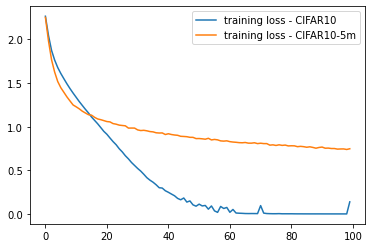

In [ ]:
fig=plt.figure()
plt.plot(stats_cifar10_LeNetFC['training_loss_history'], label='training loss - CIFAR10')
plt.plot(stats_cifar10_5m_training_LeNetFC['training_loss_history_5m'], label='training loss - CIFAR10-5m')
plt.legend()

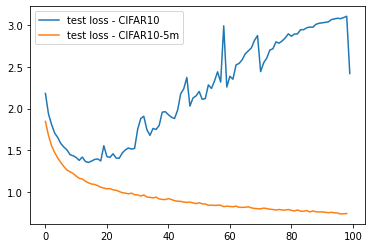

In [ ]:
fig=plt.figure()
plt.plot(stats_cifar10_LeNetFC['test_loss_history'], label='test loss - CIFAR10')
plt.plot(stats_cifar10_5m_test_LeNetFC['test_loss_history_5m'], label='test loss - CIFAR10-5m')
plt.legend()

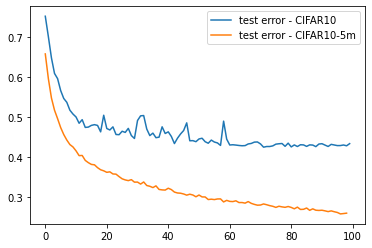

In [ ]:
fig=plt.figure()
plt.plot(stats_cifar10_LeNetFC['test_error_history'], label='test error - CIFAR10')
plt.plot(stats_cifar10_5m_test_LeNetFC['test_error_history_5m'], label='test error - CIFAR10-5m')
plt.legend()

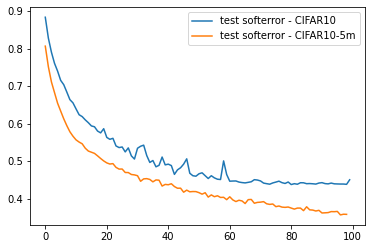

In [ ]:
fig=plt.figure()
plt.plot(stats_cifar10_LeNetFC['test_softerror_history'], label='test softerror - CIFAR10')
plt.plot(stats_cifar10_5m_test_LeNetFC['test_softerror_history_5m'], label='test softerror - CIFAR10-5m')
plt.legend()

In [ ]:
stats_cifar10_5m = pickle.load(open("stats_cifar10_5m.pkl", 'rb'))
stats_cifar10 = pickle.load(open("stats_cifar10.pkl", 'rb'))

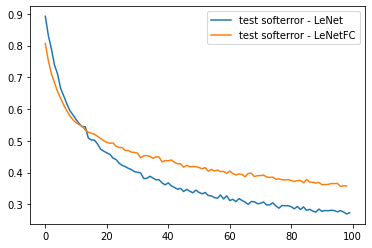

In [ ]:
fig=plt.figure()
plt.plot(stats_cifar10_5m['test_softerror_history_5m'], label='test softerror - CIFAR10-5m - LeNet')
plt.plot(stats_cifar10_5m_test_LeNetFC['test_softerror_history_5m'], label='test softerror -  CIFAR10-5m - LeNetFC')
plt.legend()

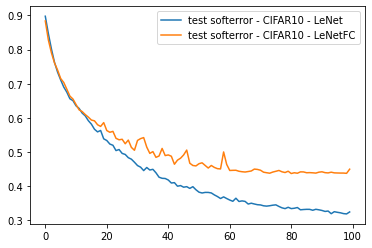

In [ ]:
fig=plt.figure()
plt.plot(stats_cifar10['test_softerror_history'], label='test softerror - CIFAR10 - LeNet')
plt.plot(stats_cifar10_LeNetFC['test_softerror_history'], label='test softerror - CIFAR10 - LeNetFC')
plt.legend()